## Running 'model_2' with 10% of the training data 

In [1]:
from helper_functions import *

In [2]:
# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2024-07-12 13:49:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4009:81e::201b, 2404:6800:4009:81f::201b, 2404:6800:4009:820::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4009:81e::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: '10_food_classes_10_percent.zip'

     0K .......... .......... .......... .......... ..........  0%  108K 25m20s
    50K .......... .......... .......... .......... ..........  0%  166K 20m55s
   100K .......... .......... .......... .......... ..........  0%  418K 16m8s
   150K .......... .......... .......... .......... ..........  0%  404K 13m47s
   200K .......... .......... .......... .......... ..........  0%  534K 12m3s
   250K .......... .......... .......... .......... ..........  0%  770K 10m38s
   300K .......... ......

In [3]:
train_dir_10_percent = "C:/Tensorflow/Section 5 Transer Learning Part 2 Fine Tuning/10_food_classes_10_percent/train"
test_dir_10_percent = "C:/Tensorflow/Section 5 Transer Learning Part 2 Fine Tuning/10_food_classes_10_percent/test"

In [4]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [5]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_dir_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32,
                                                                           image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10_percent,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name = "data_augmentation")

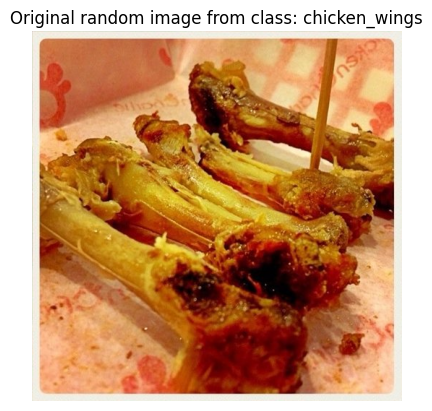

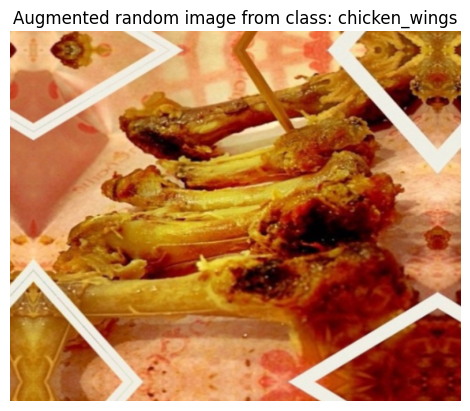

In [7]:
# Viewing a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_dir_10_percent.class_names)
target_dir = "C:/Tensorflow/Section 5 Transer Learning Part 2 Fine Tuning/10_food_classes_10_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)

augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);


Building our model

In [8]:
# Setup input shape and base model, freeze the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False, input_shape=input_shape)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

train_dir_10_percent = "C:/Tensorflow/Section 5 Transer Learning Part 2 Fine Tuning/10_food_classes_10_percent/train"
test_dir_10_percent = "C:/Tensorflow/Section 5 Transer Learning Part 2 Fine Tuning/10_food_classes_10_percent/test"

# Load the datasets 
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_10_percent,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)


# Function to convert integer labels to one-hot encoded labels
def one_hot_encode(dataset, num_classes=10):
    def encode(image, label):
        label = tf.one_hot(label, num_classes)
        return image, label
    return dataset.map(encode)

# One-hot encode the datasets
train_dataset = one_hot_encode(train_dataset)
validation_dataset = one_hot_encode(validation_dataset)

# # Placeholder for creating a tensorboard callback
# def create_tensorboard_callback(dir_name, experiment_name):
#     log_dir = f"{dir_name}/{experiment_name}"
#     tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
#     return tensorboard_callback


Found 750 files belonging to 10 classes.
Using 600 files for training.
Found 2500 files belonging to 10 classes.
Using 500 files for validation.


In [9]:
# Setup check point path
checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch",
                                                         verbose=1)

In [10]:
initial_epochs = 10

history_10_percent = model_1.fit(train_dataset,
                                 epochs=initial_epochs,
                                 validation_data=validation_dataset,
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240712-135055
Epoch 1/10
19/19 [==============================] - ETA: 0s - loss: 2.0894 - accuracy: 0.2933
Epoch 1: val_loss improved from inf to 1.60911, saving model to 10_percent_model_checkpoints_weights\checkpoint.ckpt
19/19 [==============================] - 59s 2s/step - loss: 2.0894 - accuracy: 0.2933 - val_loss: 1.6091 - val_accuracy: 0.6000
Epoch 2/10
19/19 [==============================] - ETA: 0s - loss: 1.5480 - accuracy: 0.5950
Epoch 2: val_loss improved from 1.60911 to 1.19539, saving model to 10_percent_model_checkpoints_weights\checkpoint.ckpt
19/19 [==============================] - 26s 1s/step - loss: 1.5480 - accuracy: 0.5950 - val_loss: 1.1954 - val_accuracy: 0.7380
Epoch 3/10
19/19 [==============================] - ETA: 0s - loss: 1.2360 - accuracy: 0.7050
Epoch 3: val_loss improved from 1.19539 to 0.93973, saving model to 10_percent_model_checkpoints_weights\checkpoint.ckpt
19/19 [=======

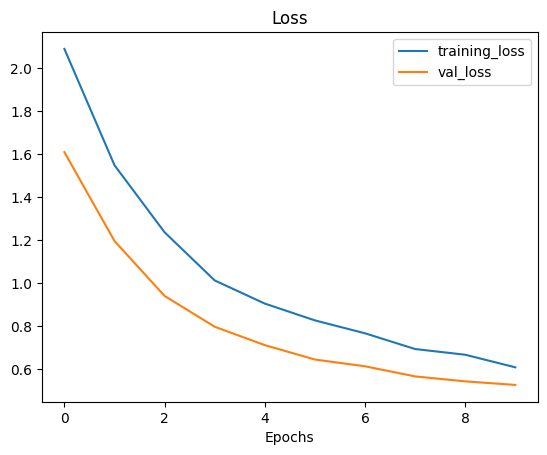

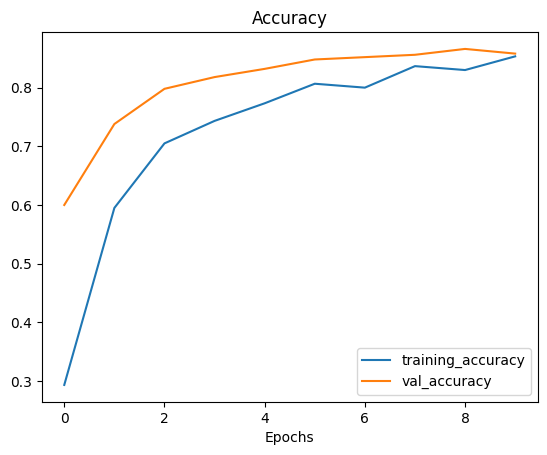

In [11]:
plot_loss_curves(history_10_percent)

In [12]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                             

In [13]:
# Load the test dataset
results = model_1.evaluate(test_data)
results

79/79 [==============================] - 11s 126ms/step - loss: 0.5478 - accuracy: 0.8444


[0.547846257686615, 0.8443999886512756]

In [14]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0

## Loading in check point waights

In [15]:
model_1.load_weights(checkpoint_path)

In [16]:
# Evaluate model_1 with loaded weights
loaded_weights_model_results = model_1.evaluate(test_data)
loaded_weights_model_results

79/79 [==============================] - 9s 108ms/step - loss: 0.5478 - accuracy: 0.8444


[0.5478461980819702, 0.8443999886512756]

In [17]:
# If the results frm our previusly evaluated model_2 match with the loaded weights, everything has worked!
results == loaded_weights_model_results

False

In [18]:
results

[0.547846257686615, 0.8443999886512756]

In [19]:
# Check to see if loaded model results are very close to our non loaded model results
import numpy as np
np.isclose(np.array(results), np.array(loaded_weights_model_results))

array([ True,  True])

In [20]:
# Checking the difference
print(np.array(results) - np.array(loaded_weights_model_results))

[5.96046448e-08 0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

>**Note:** Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data 

In [21]:
# Layers in loaded_model
model_1.layers

In [22]:
# Are these layers trainable?
for layer in model_1.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001F3633060E0> True
<keras.engine.sequential.Sequential object at 0x000001F331C036A0> True
<keras.engine.functional.Functional object at 0x000001F36331FFD0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000001F36331E2C0> True
<keras.layers.core.dense.Dense object at 0x000001F3615E1690> True


In [23]:
for i, layer in enumerate(model_1.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

In [24]:
# How many trainable variables are in our base model?
print(len(model_1.layers[2].trainable_variables))

0


In [25]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (we have to recommpile our models every time we make a change)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),   # when fine tuning we want to lower lr by 10x to prevent overfitting
                metrics=["accuracy"])

**Note:** It is always recommended when fine-tuning always reduce the learning rate. Good rule of thumb is at least 10x

In [26]:
# Check which layers are tunable
for layer_number, layer in enumerate(model_1.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

### Now we have unfroze last 10 layers

In [27]:
print(len(model_1.trainable_variables))

12


In [28]:
# Fine-tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model
history_fine_10_percent_data_aug = model_1.fit(train_dataset,
                                               epochs=fine_tune_epochs,
                                               validation_data=validation_dataset,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent.epoch[-1],
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240712-135546
Epoch 10/15
19/19 [==============================] - 55s 2s/step - loss: 0.5664 - accuracy: 0.8383 - val_loss: 0.4469 - val_accuracy: 0.8620
Epoch 11/15
19/19 [==============================] - 21s 1s/step - loss: 0.4778 - accuracy: 0.8400
Epoch 12/15
19/19 [==============================] - 16s 830ms/step - loss: 0.4228 - accuracy: 0.8717
Epoch 13/15
19/19 [==============================] - 16s 835ms/step - loss: 0.4008 - accuracy: 0.8817
Epoch 14/15
19/19 [==============================] - 16s 813ms/step - loss: 0.3975 - accuracy: 0.8800
Epoch 15/15
19/19 [==============================] - 16s 821ms/step - loss: 0.3505 - accuracy: 0.8883


In [29]:
# Evaluatin the models
results_fine_tune_10_percent = model_1.evaluate(test_data)

79/79 [==============================] - 10s 114ms/step - loss: 0.4222 - accuracy: 0.8572


In [34]:
import matplotlib.pyplot as plt

def plot_loss_curves_fine_tune(history):
    """
    Returns separate loss curves for training and validation metrics.

    Args:
        history: TensorFlow model History object
    """ 
    # Extracting values from the history object
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    accuracy = history.history.get('accuracy', [])
    val_accuracy = history.history.get('val_accuracy', [])
    
    # Debugging: Print the lengths of the arrays
    print(f"Length of loss: {len(loss)}")
    print(f"Length of val_loss: {len(val_loss)}")
    print(f"Length of accuracy: {len(accuracy)}")
    print(f"Length of val_accuracy: {len(val_accuracy)}")

    epochs = range(len(loss))

    # Plot loss
    plt.figure()
    plt.plot(epochs, loss, label='training_loss')
    if len(val_loss) == len(epochs):
        plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    if len(val_accuracy) == len(epochs):
        plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

Length of loss: 6
Length of val_loss: 1
Length of accuracy: 6
Length of val_accuracy: 1


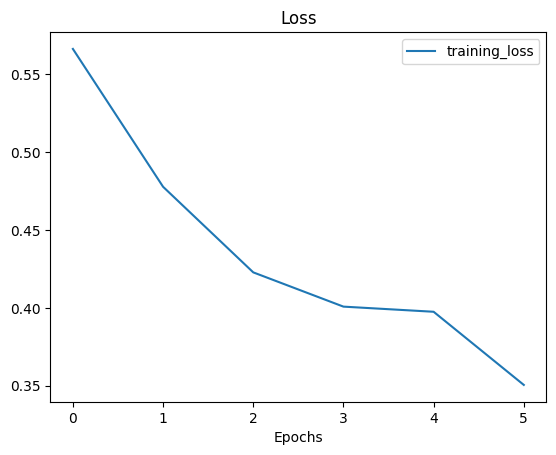

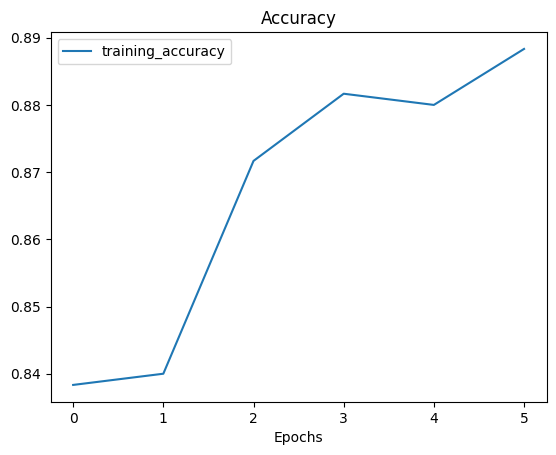

In [35]:
# Check out the loss courves of our fine tune model
plot_loss_curves_fine_tune(history_fine_10_percent_data_aug)